In [1]:
import sys
sys.path.append("lib") # go to parent dir
import os
from lib import mri_data_generator
from lib import models
from lib import motion
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
def get_mid_slice(vol_data,n):
    _,_,z = vol_data.shape

    sl_data = vol_data[:,:,int(z/2)]
    sl_data = np.array(Image.fromarray(sl_data).resize((n,n)))
    sl_data = sl_data - sl_data.mean()
    sl_data = sl_data/np.max(sl_data)
    return sl_data

def get_corrupted_data(dir_name,image_names,n,k_line,input_domain,output_domain,img_jump=1):
    img=image_names
    vol_data = np.load(os.path.join(dir_name,img))['vol_data']
    sl_data = get_mid_slice(vol_data,n)


    if(True):
        if(sl_data.shape!=(n,n) or np.isnan(sl_data).any()):
            pass
        end = -(len('.npz')) #end index of volume number
        num_len = 4
        start = end-num_len #start index of volume number
        next_img = int(img[start:end])+img_jump
        next_name = img[:start]+str(next_img).zfill(4)+'.npz'
        try:
            next_img_vol = np.load(os.path.join(dir_name,next_name))['vol_data']
            next_img_sl = get_mid_slice(next_img_vol,n)
            if(next_img_sl.shape!=(n,n) or np.isnan(next_img_sl).any() or np.isnone(next_img_sl).any()):
                pass
        except:
            pass
        corrupted_img,corrupted_k = motion.add_next_frame(sl_data,next_img_sl,k_line,return_k=True)
    else:
        corrupted_img,corrupted_k = motion.add_rotation_and_translation(sl_data,angle,num_pix,k_line,return_k=True)

    corrupted_k = np.expand_dims(corrupted_k,-1)
    corrupted_k_re = np.real(corrupted_k)
    corrupted_k_im = np.imag(corrupted_k)
    corrupted_k = np.concatenate([corrupted_k_re,corrupted_k_im], axis=2)
    if(output_domain=='IMAGE'):
        pass
    elif(output_domain=='FREQUENCY'):
        true_k = np.expand_dims(np.fft.fftshift(np.fft.fft2(sl_data)), axis=-1)
        true_k_re = np.real(true_k)
        true_k_im = np.imag(true_k)
        true_k = np.concatenate([true_k_re,true_k_im], axis=2)

    if(input_domain=='FREQUENCY'):
        return corrupted_k
        inputs.append(corrupted_k)
    elif(input_domain=='IMAGE'):
        return corrupted_img
        inputs.append(np.expand_dims(corrupted_img,axis=-1))

In [3]:
n=64

# Set up BOLD AUTOMAP model
bold_automap_model = models.get_full_model(n)
bold_automap_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
bold_automap_model.load_weights('training/debug-BOLD-SEQUENTIAL-STANDARD-relu-FREQUENCY_INDOMAIN-IMAGE_OUTDOMAIN-False-500epoch-64/cp-0085.ckpt')

# Set up BOLD UNet model
bold_unet_model = models.get_Unet(n,'relu', (n,n,1))
bold_unet_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
bold_unet_model.load_weights('training/debug-BOLD-SEQUENTIAL-UNET-relu-IMAGE_INDOMAIN-IMAGE_OUTDOMAIN-False-500epoch-64/cp-0055.ckpt')

In [4]:
label = '030315'
dir_name = '/data/vision/polina/scratch/nmsingh/bold-data/test/'+label+'/'
frame = 10
img_jump = 30
image_name = label+'_'+str(frame).zfill(4)+'.npz'
next_image_name = label+'_'+str(frame+img_jump).zfill(4)+'.npz'

vol_data = np.load(os.path.join(dir_name,image_name))['vol_data']
vol_next_data = np.load(os.path.join(dir_name,next_image_name))['vol_data']
sl = get_mid_slice(vol_data,64)
next_sl = get_mid_slice(vol_next_data,64)

k_line = 32
mix_img_k = get_corrupted_data(dir_name,image_name,64,k_line,'FREQUENCY','IMAGE',img_jump)
mix_img = np.real(get_corrupted_data(dir_name,image_name,64,k_line,'IMAGE','IMAGE',img_jump))
automap_recon = bold_automap_model.predict(np.expand_dims(mix_img_k,0))[0,:,:,0]
unet_recon = bold_unet_model.predict(np.expand_dims(np.expand_dims(mix_img,0),-1))[0,:,:,0]


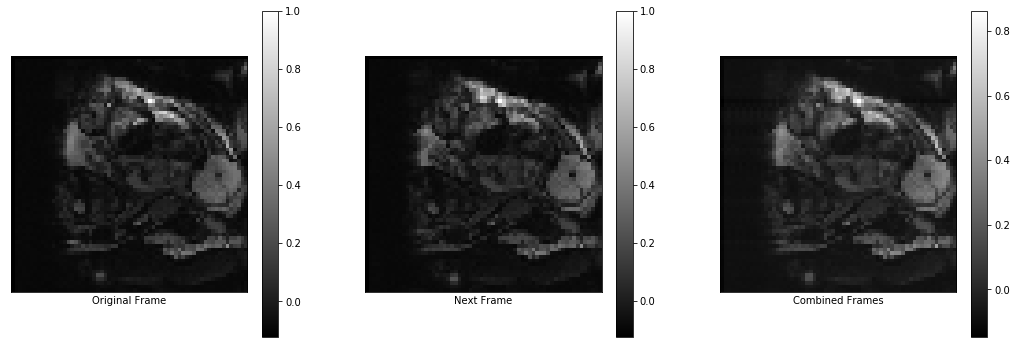

In [5]:
fig,axes = plt.subplots(1,3, figsize=[18,6])

im=axes[0].imshow(sl,cmap='gray')
axes[0].set_xlabel('Original Frame')
plt.colorbar(im,ax=axes[0])

im=axes[1].imshow(next_sl,cmap='gray')
axes[1].set_xlabel('Next Frame')
plt.colorbar(im,ax=axes[1])

im=axes[2].imshow(mix_img,cmap='gray')
axes[2].set_xlabel('Combined Frames')
plt.colorbar(im,ax=axes[2])

for i,iax in enumerate(axes.flatten()):
    iax.set_yticks([])
    iax.set_xticks([])

<Figure size 432x288 with 0 Axes>

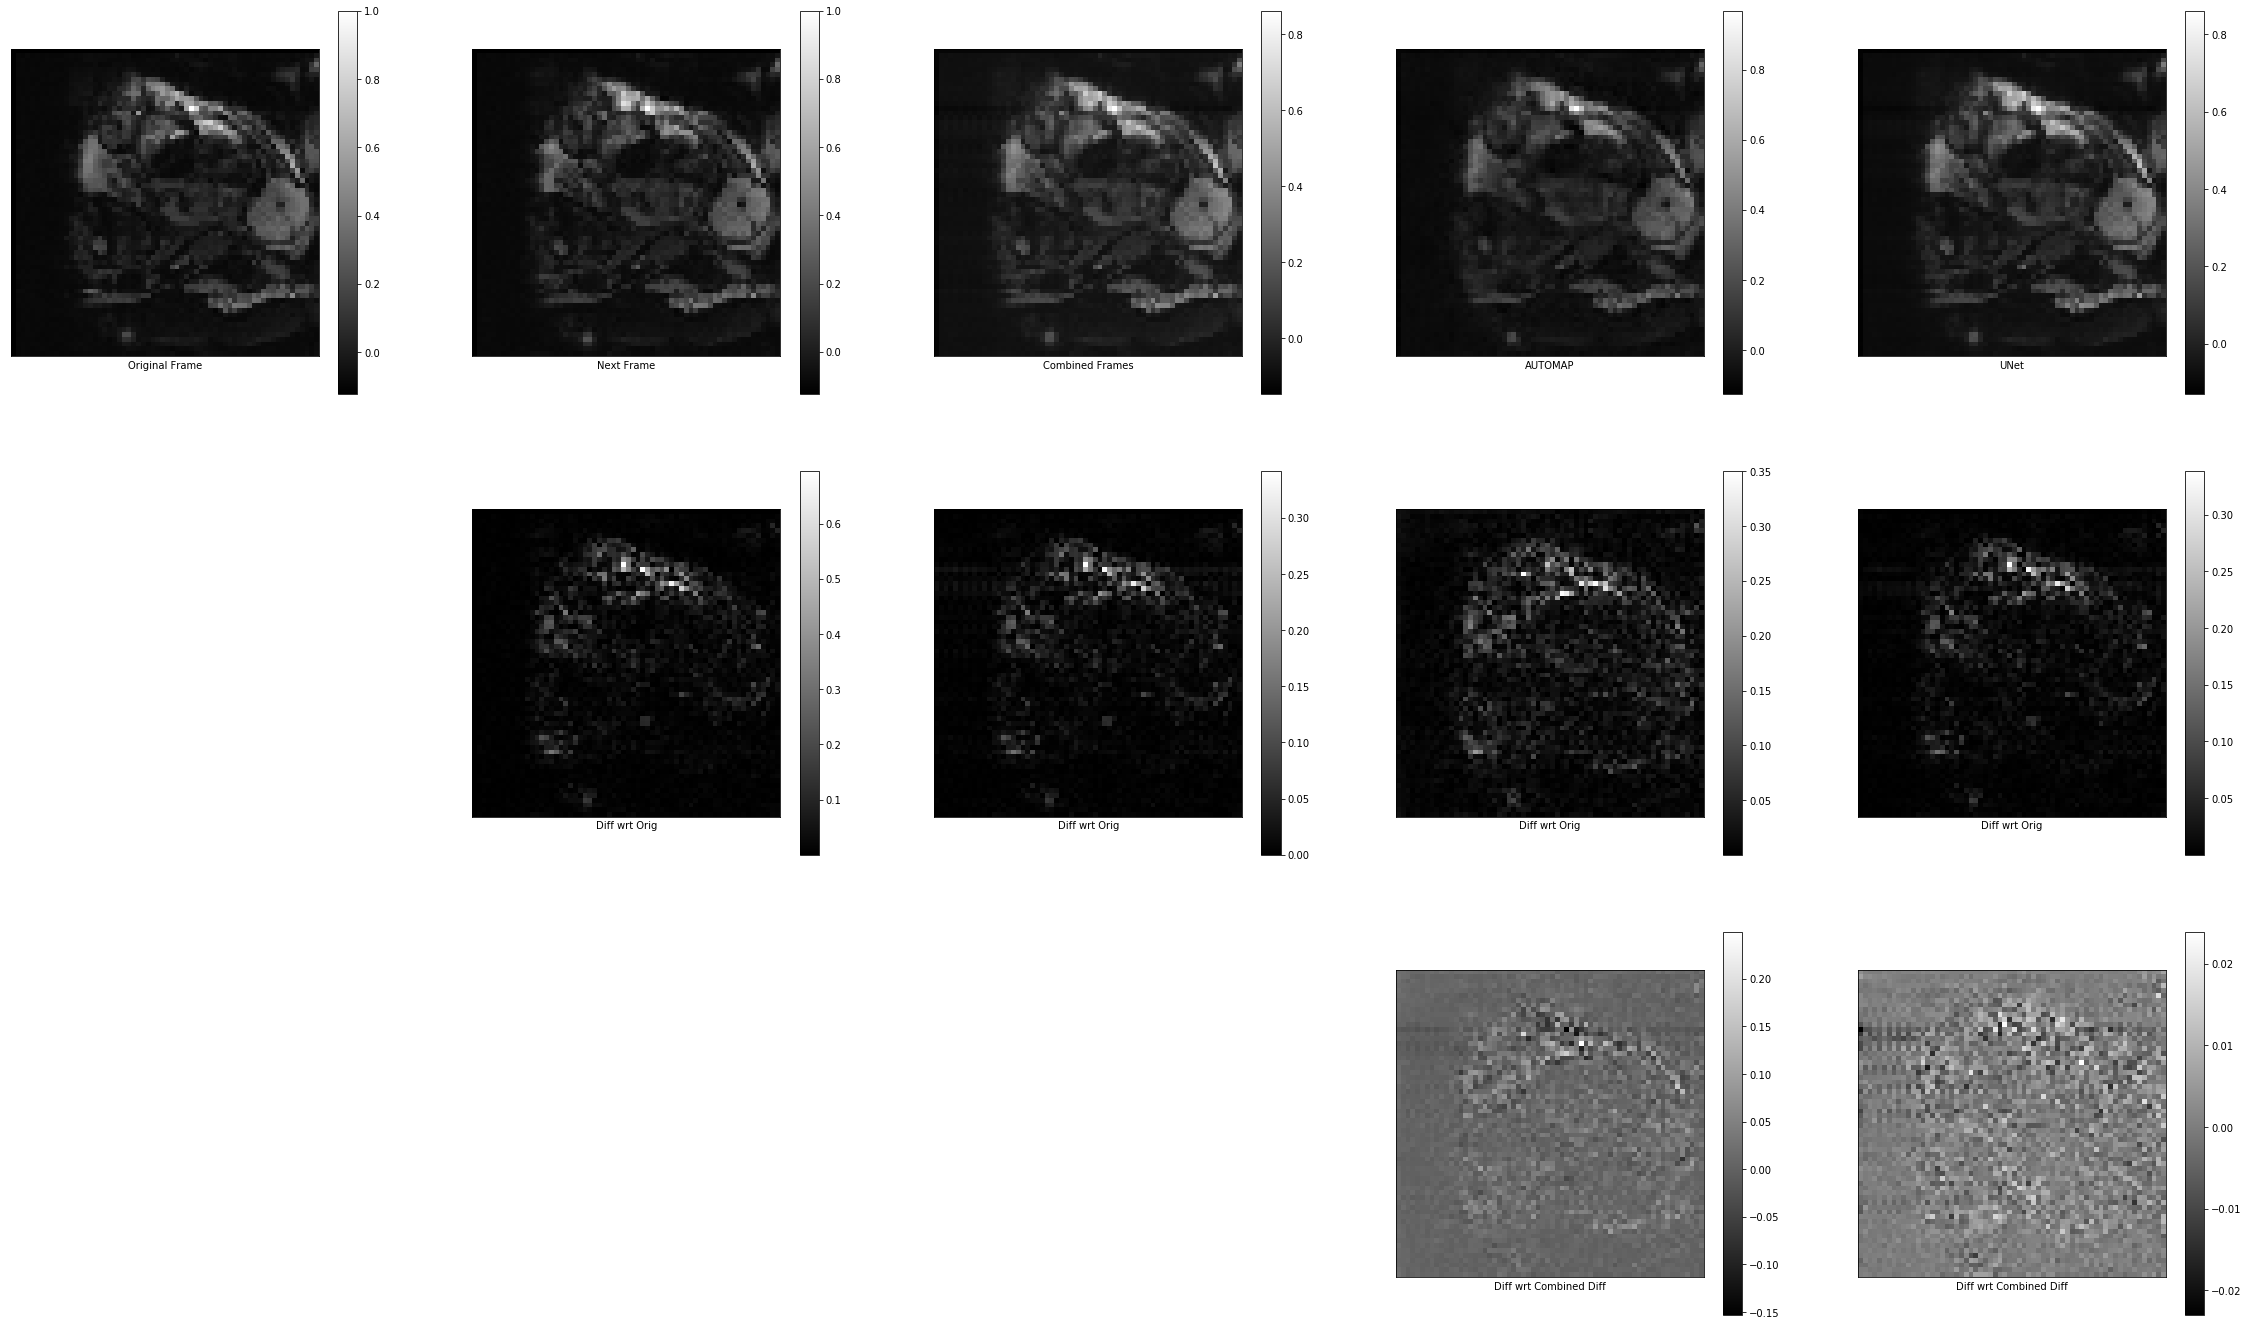

In [6]:
plt.figure()
fig,axes = plt.subplots(3,5, figsize=[40,24])

im=axes[0][0].imshow(sl,cmap='gray')
axes[0][0].set_xlabel('Original Frame')
plt.colorbar(im,ax=axes[0][0])

im=axes[0][1].imshow(next_sl,cmap='gray')
axes[0][1].set_xlabel('Next Frame')
plt.colorbar(im,ax=axes[0][1])

im=axes[0][2].imshow(mix_img,cmap='gray')
axes[0][2].set_xlabel('Combined Frames')
plt.colorbar(im,ax=axes[0][2])

im=axes[0][3].imshow(automap_recon,cmap='gray')
axes[0][3].set_xlabel('AUTOMAP')
plt.colorbar(im,ax=axes[0][3])

im=axes[0][4].imshow(unet_recon,cmap='gray')
axes[0][4].set_xlabel('UNet')
plt.colorbar(im,ax=axes[0][4])

axes[1][0].axis('off')

im=axes[1][1].imshow(np.abs(next_sl-sl),cmap='gray')
axes[1][1].set_xlabel('Diff wrt Orig')
plt.colorbar(im,ax=axes[1][1])

im=axes[1][2].imshow(np.abs(mix_img-sl),cmap='gray')
axes[1][2].set_xlabel('Diff wrt Orig')
plt.colorbar(im,ax=axes[1][2])

im=axes[1][3].imshow(np.abs(automap_recon-sl),cmap='gray')
axes[1][3].set_xlabel('Diff wrt Orig')
plt.colorbar(im,ax=axes[1][3])

im=axes[1][4].imshow(np.abs(unet_recon-sl),cmap='gray')
axes[1][4].set_xlabel('Diff wrt Orig')
plt.colorbar(im,ax=axes[1][4])

axes[2][0].axis('off')

axes[2][1].axis('off')

axes[2][2].axis('off')

im=axes[2][3].imshow(np.abs(automap_recon-sl)-np.abs(mix_img-sl),cmap='gray')
axes[2][3].set_xlabel('Diff wrt Combined Diff')
plt.colorbar(im,ax=axes[2][3])

im=axes[2][4].imshow(np.abs(unet_recon-sl)-np.abs(mix_img-sl),cmap='gray')
axes[2][4].set_xlabel('Diff wrt Combined Diff')
plt.colorbar(im,ax=axes[2][4])

for i,iax in enumerate(axes.flatten()):
    iax.set_yticks([])
    iax.set_xticks([])